Understanding DCGAN and WGAN

References:
 - https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
 - https://github.com/Zeleni9/pytorch-wgan

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision import utils
from torch.autograd import Variable

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:
# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 64

# Number of training epochs
num_epochs = 10

# Number of GPUs
ngpu = 1

In [0]:
# Load Data - Used Fashion MNIST for experiments

fashion_mnist = torchvision.datasets.FashionMNIST(
    root = '../content/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
    ])
)

dataloader = torch.utils.data.DataLoader(fashion_mnist,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Extracting ../content/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../content/FashionMNIST/FashionMNIST/raw


Extracting ../content/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../content/FashionMNIST/FashionMNIST/raw


Extracting ../content/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../content/FashionMNIST/FashionMNIST/raw




Extracting ../content/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../content/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


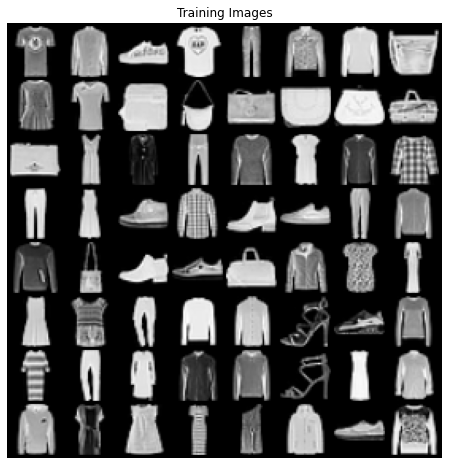

In [0]:
# Plot some training images

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

**DCGAN**

In [0]:
class Generator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0),
        nn.BatchNorm2d(num_features=1024),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )
  
  def forward(self, x):
    return self.main(x)

# Discriminator architecture with wgan flag. Since, in WGAN discriminator is used to compute the difference between real image and generate image
# output is taken from linear layer instead of sigmoid layer

class Discriminator(torch.nn.Module):
  def __init__(self, wgan = False):
    super().__init__()
    self.main = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=256, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2, inplace=True),        
        nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=2, padding=0)
    )
    self.sigmoid = nn.Sigmoid()
    self.wgan = wgan

  def forward(self, x):
    if self.wgan:
      return self.main(x)
    else:
      return self.sigmoid(self.main(x))

In [0]:
# Pending - Add logger 
class dcgan_model(object):
  def __init__(self, epochs, batch_size):
    print('Model Initilization')
    self.G = Generator().to(device)
    self.D = Discriminator().to(device)
    # binary cross entropy loss and optimizer
    self.loss = nn.BCELoss()
    self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
    self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr = 0.0002, betas = (0.5, 0.999))
    self.epochs = epochs
    self.batch_size = batch_size

  def train(self, train_loader):
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    for epoch in range(self.epochs):
      for i, (images, _) in enumerate(train_loader):
        if i == train_loader.dataset.__len__() // self.batch_size:
          break
        
        z = torch.randn(self.batch_size, 100, 1, 1, device = device)
        real_labels = torch.ones(self.batch_size, device = device)
        fake_labels = torch.zeros(self.batch_size, device = device)
        images = images.to(device)

        # Discriminator
        self.D.zero_grad()
        outputs = self.D(images).view(-1)
        d_loss_real = self.loss(outputs, real_labels)
        d_loss_real.backward()
        real_score = outputs

        fake_images = self.G(z)
        outputs = self.D(fake_images.detach()).view(-1)
        d_loss_fake = self.loss(outputs, fake_labels)
        d_loss_fake.backward()
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        self.d_optimizer.step()
        
        # Generator
        self.G.zero_grad()
        outputs = self.D(fake_images).view(-1)
        g_loss = self.loss(outputs, real_labels)
        g_loss.backward()
        self.g_optimizer.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, self.epochs, i, len(dataloader),
                     d_loss.item(), g_loss.item()))
            
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        
        if (iters % 500 == 0) or ((epoch == self.epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = self.G(z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    return img_list, G_losses, D_losses


  def evaluate(self):

    z = torch.randn(self.batch_size, 100, 1, 1, device = device)
    samples = self.G(z)
    samples = samples.mul(0.5).add(0.5)
    samples = samples.data.cpu()
    grid = np.transpose(utils.make_grid(samples).cpu(),(1,2,0))
    plt.figure(figsize=(8,8))
    plt.imshow(grid)

  def generate_latent_walk(self):
    
    number_int = 10
    z_intp = torch.FloatTensor(1, 100, 1, 1).to(device)
    z1 = torch.randn(1, 100, 1, 1, device = device)
    z2 = torch.randn(1, 100, 1, 1, device = device)
    images = []
    alpha = 1.0/ float(number_int + 1)
    print(alpha)
    for i in range(1, number_int + 1):
      z_intp.data = z1*alpha + z2*(1.0 - alpha)
      alpha += alpha
      fake_im = self.G(z_intp)
      fake_im = fake_im.mul(0.5).add(0.5) 
      images.append(fake_im.view(1, 32, 32).data.cpu())
    grid = np.transpose(utils.make_grid(images, nrow = number_int), (1,2,0))
    plt.figure(figsize=(10,8))
    plt.imshow(grid)
    return grid

In [0]:
dcgan = dcgan_model(num_epochs, batch_size)
img_list, g_loss, d_loss = dcgan.train(dataloader)

Model Initilization
[0/5][0/938]	Loss_D: 1.2571	Loss_G: 7.9426	
[0/5][50/938]	Loss_D: 0.0099	Loss_G: 6.8118	
[0/5][100/938]	Loss_D: 0.0368	Loss_G: 4.7339	
[0/5][150/938]	Loss_D: 0.0099	Loss_G: 6.9090	
[0/5][200/938]	Loss_D: 1.1888	Loss_G: 3.4969	
[0/5][250/938]	Loss_D: 0.4391	Loss_G: 2.3275	
[0/5][300/938]	Loss_D: 1.1780	Loss_G: 1.1227	
[0/5][350/938]	Loss_D: 0.9989	Loss_G: 1.8708	
[0/5][400/938]	Loss_D: 0.8459	Loss_G: 2.4259	
[0/5][450/938]	Loss_D: 1.1576	Loss_G: 1.0902	
[0/5][500/938]	Loss_D: 1.0767	Loss_G: 1.0875	
[0/5][550/938]	Loss_D: 1.1071	Loss_G: 1.7080	
[0/5][600/938]	Loss_D: 1.0555	Loss_G: 2.1575	
[0/5][650/938]	Loss_D: 1.1923	Loss_G: 0.9563	
[0/5][700/938]	Loss_D: 1.2036	Loss_G: 0.9291	
[0/5][750/938]	Loss_D: 1.2848	Loss_G: 3.6128	
[0/5][800/938]	Loss_D: 1.0954	Loss_G: 1.2264	
[0/5][850/938]	Loss_D: 0.9163	Loss_G: 1.7959	
[0/5][900/938]	Loss_D: 0.9020	Loss_G: 1.6644	
[1/5][0/938]	Loss_D: 1.0570	Loss_G: 1.2586	
[1/5][50/938]	Loss_D: 0.5054	Loss_G: 1.6446	
[1/5][100/938]	Loss_

0.09090909090909091


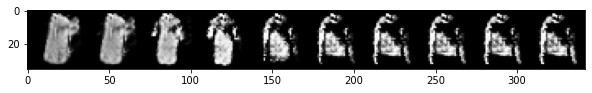

In [0]:
lw = dcgan.generate_latent_walk()

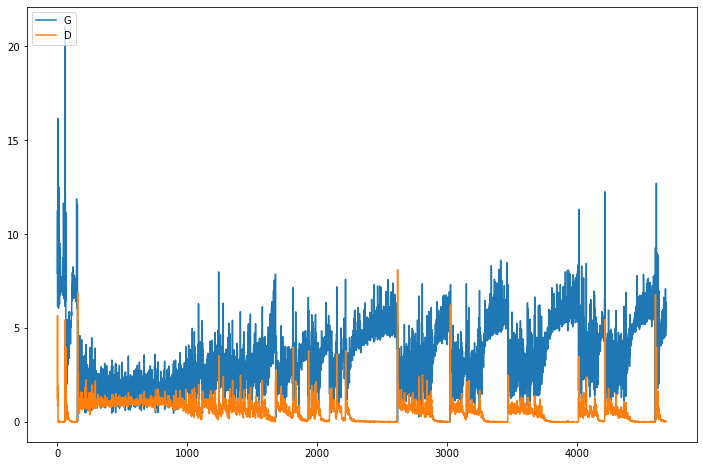

In [0]:
plt.figure(figsize = (12, 8))
plt.plot(g_loss, label = 'G',)
plt.plot(d_loss, label = 'D')
plt.legend(loc='upper left')
plt.show()

**WGAN**

In [0]:
class wgan_cp(object):
  def __init__(self, batch_size, generator_iters):
    print('Model Initilization')
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    self.G = Generator().to(device)
    self.D = Discriminator(wgan=True).to(device)
    self.learning_rate = 0.00005
    self.batch_size = batch_size
    self.weight_cliping_limit = 0.01
    self.d_optimizer = torch.optim.RMSprop(self.D.parameters(), lr = self.learning_rate)
    self.g_optimizer = torch.optim.RMSprop(self.G.parameters(), lr = self.learning_rate)
    self.critic_iter = 5
    self.generator_iters = generator_iters 

  def train(self, train_loader):
    
    w_distance = []
    loss_d = []
    loss_g = []
    loss_d_real = []
    loss_d_fake = []

    self.data = self.get_infinite_batches(train_loader)
    one = torch.FloatTensor([1])
    mone = one * -1
    one = one.cuda()
    mone = mone.cuda()

    for g_iter in range(self.generator_iters):
      for p in self.D.parameters():
        p.requires_grad = True
      
      # Discriminator
      for d_iter in range(self.critic_iter):
        self.D.zero_grad()
        for p in self.D.parameters():
          p.data.clamp_(-self.weight_cliping_limit, self.weight_cliping_limit)

        images = self.data.__next__().to(device)
        if images.size()[0] != self.batch_size:
          continue
        z = torch.randn(self.batch_size, 100, 1, 1, device = device)

        d_loss_real = self.D(images)
        d_loss_real = d_loss_real.mean(0).view(1)
        d_loss_real.backward(one)

        z = Variable(torch.randn(self.batch_size, 100, 1, 1)).cuda()
        fake_images = self.G(z)
        d_loss_fake = self.D(fake_images)
        d_loss_fake = d_loss_fake.mean(0).view(1)
        d_loss_fake.backward(mone)

        d_loss = d_loss_fake - d_loss_real
        Wasserstein_D = d_loss_real - d_loss_fake
        self.d_optimizer.step()

      for p in self.D.parameters():
        p.requires_grad = False

      self.G.zero_grad()
      z = torch.randn(self.batch_size, 100, 1, 1, device = device)
      fake_images = self.G(z)
      g_loss = self.D(fake_images)
      g_loss = g_loss.mean(0).view(1)
      g_loss.backward(one)
      g_cost = -g_loss
      self.g_optimizer.step()
      if (g_iter) % 1000 == 1:
        
        # Denormalize images and save them in grid 8x8
        z = torch.randn(800, 100, 1, 1, device = device)
        samples = self.G(z)
        samples = samples.mul(0.5).add(0.5)
        samples = samples.data.cpu()[:64]
        grid = np.transpose(utils.make_grid(samples).cpu(),(1,2,0))
        plt.imshow(grid)

        print('Generator: {}, W-distance: {}, Loss D: {},, Loss G: {},\
             Loss D Real: {}, Loss D Fake: {}'.format(g_iter, Wasserstein_D.data[0], d_loss.data[0],\
                                                      g_cost.data[0], d_loss_real.data[0], d_loss_fake.data[0]))
        w_distance.append(Wasserstein_D.data[0])
        loss_d.append(d_loss.data[0])
        loss_g.append(g_cost.data[0])
        loss_d_real.append(d_loss_real.data[0])
        loss_d_fake.append(d_loss_fake.data[0])
    
    return w_distance, loss_d, loss_g, loss_d_real, loss_d_fake

  def evaluate(self):
    z = torch.randn(self.batch_size, 100, 1, 1, device = device)
    samples = self.G(z)
    samples = samples.mul(0.5).add(0.5)
    samples = samples.data.cpu()
    grid = np.transpose(utils.make_grid(samples).cpu(),(1,2,0))
    plt.imshow(grid)

  def get_infinite_batches(self, data_loader):
    while True:
      for i, (images, _) in enumerate(data_loader):
        yield images

In [0]:
wgan = wgan_cp(batch_size, 40000)
w_distance, loss_d, loss_g, loss_d_real, loss_d_fake = wgan.train(dataloader)